In [1]:
import pandas as pd
import os, json
import numpy as np
import nltk
from datetime import datetime
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

# A summary of the overall analyses is provided at the end of the file

# LOAD DATA + EXPLORATORY ANALYSIS

In [2]:
Aviation = pd.read_csv('/Users/hannahwu/Documents/data-scientist-exercise02/data/AviationData.csv')
Aviation.head(2)

EventId InvestigationType AccidentNumber   EventDate     Location  \
0  20150901X74304          Accident     GAA15CA244  09/01/2015  Truckee, CA   
1  20150901X92332          Accident     CEN15LA392  08/31/2015  Houston, TX   

         Country   Latitude  Longitude AirportCode   AirportName  ...  \
0  United States        NaN        NaN         NaN           NaN  ...   
1  United States  29.809444 -95.668889         IWS  WEST HOUSTON  ...   

  PurposeOfFlight AirCarrier TotalFatalInjuries TotalSeriousInjuries  \
0             NaN        NaN                NaN                  NaN   
1   Instructional        NaN                NaN                  NaN   

  TotalMinorInjuries TotalUninjured WeatherCondition  BroadPhaseOfFlight  \
0                NaN            NaN              NaN                 NaN   
1                NaN            2.0              VMC             LANDING   

  ReportStatus PublicationDate  
0  Preliminary             NaN  
1  Preliminary      09/04/2015  

[2 rows x 31 columns]

In [3]:
Aviation.describe()

Latitude     Longitude  NumberOfEngines  TotalFatalInjuries  \
count  23761.000000  23752.000000     73336.000000        55791.000000   
mean      37.744819    -93.807654         1.149095            0.788962   
std       12.022069     39.510021         0.463222            6.087442   
min      -78.016945   -193.216667         0.000000            0.000000   
25%       33.416389   -115.134444         1.000000            0.000000   
50%       38.190555    -94.660555         1.000000            0.000000   
75%       42.572223    -81.761944         1.000000            1.000000   
max       89.218056    177.557778        24.000000          349.000000   

       TotalSeriousInjuries  TotalMinorInjuries  TotalUninjured  
count          53744.000000        54733.000000    65862.000000  
mean               0.309895            0.492555        5.716817  
std                1.368488            2.779814       29.052413  
min                0.000000            0.000000        0.000000  
25%                0.000000            0.000000        0.000000  
50%                0.000000            0.000000        1.000000  
75%                0.000000            1.000000        2.000000  
max              111.000000          380.000000      699.000000

In [4]:
Aviation.isnull().sum()

EventId                     0
InvestigationType           0
AccidentNumber              0
EventDate                   3
Location                   81
Country                   510
Latitude                53496
Longitude               53505
AirportCode             33894
AirportName             31163
InjurySeverity            106
AircraftDamage           2384
AircraftCategory        60737
RegistrationNumber       2759
Make                       89
Model                     118
AmateurBuilt              654
NumberOfEngines          3921
EngineType               3209
FARDescription          60592
Schedule                65878
PurposeOfFlight          3598
AirCarrier              73439
TotalFatalInjuries      21466
TotalSeriousInjuries    23513
TotalMinorInjuries      22524
TotalUninjured          11395
WeatherCondition         1989
BroadPhaseOfFlight       6227
ReportStatus                0
PublicationDate         13188
dtype: int64

In [5]:
Aviation['WeatherCondition'].value_counts(normalize=True)
# Most accidents occurred under VMC
# Over 7% of accidents occurred under IMC

VMC    0.913589
IMC    0.074135
UNK    0.012276
Name: WeatherCondition, dtype: float64

In [6]:
Aviation['BroadPhaseOfFlight'].value_counts(normalize=True)
# Close to half of accidents occurred during landing and takeoff

LANDING        0.261199
TAKEOFF        0.207518
CRUISE         0.149190
MANEUVERING    0.133732
APPROACH       0.105730
TAXI           0.031818
CLIMB          0.031325
DESCENT        0.030297
GO-AROUND      0.022103
STANDING       0.016373
UNKNOWN        0.008644
OTHER          0.002070
Name: BroadPhaseOfFlight, dtype: float64

In [7]:
Aviation['PurposeOfFlight'].value_counts(normalize=True)
# Most flights involved in these accidents were for personal purposes.

Personal                     0.588659
Instructional                0.125877
Unknown                      0.091829
Aerial Application           0.058214
Business                     0.052024
Positioning                  0.020188
Other Work Use               0.014852
Ferry                        0.010426
Public Use                   0.009598
Aerial Observation           0.008757
Executive/Corporate          0.006910
Flight Test                  0.003964
Air Race/Show                0.001806
Skydiving                    0.001439
Public Aircraft - Federal    0.001127
Banner Tow                   0.001045
External Load                0.001018
Public Aircraft - State      0.000692
Public Aircraft - Local      0.000665
Glider Tow                   0.000543
Fire Fighting                0.000258
Air Drop                     0.000109
Name: PurposeOfFlight, dtype: float64

In [8]:
Aviation['NumberOfEngines'].value_counts(normalize=True)
# More than 80% of aircrafts involved in these accidents had just one engine

1.0     0.838129
2.0     0.134368
0.0     0.015436
3.0     0.006504
4.0     0.005536
24.0    0.000014
18.0    0.000014
Name: NumberOfEngines, dtype: float64

In [9]:
# Event Date is string
# Convert it to date

# convert_to_date function to catch any value not conforming to specified format
def convert_to_date(string):
    try:
        return datetime.strptime(string, '%m/%d/%Y')
    except:
        return None

# Creating a date and a year variable
Aviation['Date'] = Aviation['EventDate'].apply(lambda x: convert_to_date(x))
Aviation['Year'] = Aviation['Date'].apply(lambda x: x.year)
Aviation['Year'] = Aviation['Year'].astype('Int32')

<AxesSubplot:title={'center':'Number of accidents over time'}>

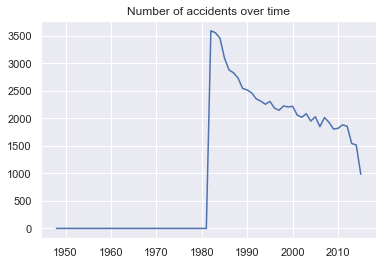

In [10]:
# Check number of accidents over time
accidents_over_time = Aviation['Year'].value_counts().sort_index()
accidents_over_time.plot.line(title='Number of accidents over time')

# The data covers the period mainly between 1982 and 2015
# Airplane accidents went down substantially over time

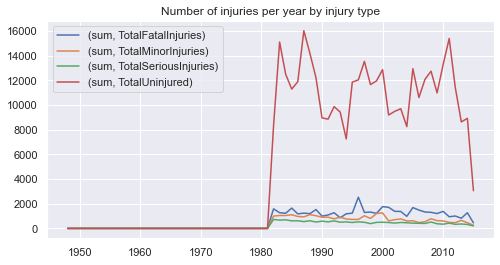

In [11]:
# Annual total injuries over time by injury type

pivot = pd.pivot_table(Aviation, index = ['Year'],
              values = ['TotalFatalInjuries', 'TotalSeriousInjuries',
                       'TotalMinorInjuries', 'TotalUninjured'],
              aggfunc= [np.sum])
pivot.plot(figsize=(8,4), title= 'Number of injuries per year by injury type')
plt.xlabel('')
plt.legend(title='')
plt.show()

# Most person involved in aviation accidents were uninjured
# There was a spike of fatal injuries in 2008

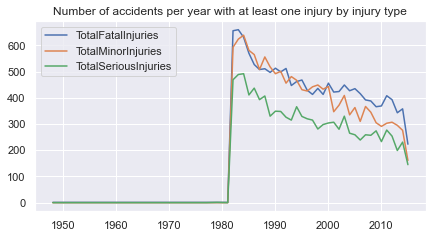

In [12]:
# Annual total accidents in which the targeted type of injury > 0 

pivot = pd.pivot_table(Aviation, index = ['Year'],
              values = ['TotalFatalInjuries', 'TotalSeriousInjuries',
                      'TotalMinorInjuries'],
              aggfunc= lambda x: (x>0).sum())

pivot.plot(figsize=(7,3.5),
           title = 'Number of accidents per year with at least one injury by injury type')
plt.xlabel('')
plt.show()

# Annual accidents that caused at least one injury of each type went down substantially over time.

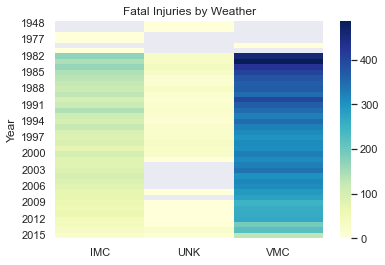

Index(['IMC', 'UNK', 'VMC'], dtype='object')

In [13]:
# Weather and fatal injuries

pivot_weather = pd.pivot_table(Aviation, index = ['Year'],
                              values = ['TotalFatalInjuries'],
                              columns = ['WeatherCondition'],
                              aggfunc= lambda x: (x>0).sum())
pivot_weather.columns =[j for i, j in pivot_weather.columns]

ax = sns.heatmap(pivot_weather, cmap='YlGnBu')
plt.xlabel('')
plt.title('Fatal Injuries by Weather')
plt.show()
pivot_weather.columns

# Most accidents with fatal injuries occurred under VMC, when there was better visibility.

In [14]:
# LOAD JSON FILES

In [16]:
path_to_json = '/Users/hannahwu/Documents/data-scientist-exercise02/data/'
# finding files ending with '.json' in the directory
# storing names of all json files in a list
json_files = [os.path.join(path_to_json,pos_json) for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

In [17]:
# creating a dataframe to store all json files
Narrative = pd.DataFrame()
# using a list to temporarily store all data frames inside the loop to reduce time complexity
temp = []
# looping through all json files
for js in json_files:
    with open(js) as json_file:
        json_text = json.load(json_file) # read as dict
        df = pd.json_normalize(json_text, record_path='data') # flatten nested dict structure to data frame
        temp.append(df) #append data frame to the list
# after the loop, temp contains a list of 144 data frames
# concatenating data frames in a single operation
Narrative = pd.concat(temp)

In [18]:
# Descrive info 

In [19]:
len(Narrative)

76133

In [20]:
Narrative.head()

EventId                                          narrative  \
0  20100412X54138  NTSB investigators used data provided by vario...   
1  20001212X22328  NTSB investigators may have traveled in suppor...   
2  20001211X11810  NTSB investigators may not have traveled in su...   
3  20001207X04295  NTSB investigators may not have traveled in su...   
4  20030827X01411  NTSB investigators may not have traveled in su...   

                                      probable_cause  
0  The pilot's failure to maintain directional co...  
1  A total loss of engine power for undetermined ...  
2   THE STUDENT PILOT'S FAILURE TO MAINTAIN AIRCR...  
3  the accidental discharge of a spear gun by the...  
4  The failure of the exhaust valve on the number...

In [21]:
# Changing 'probable_cause' to all lower cases
Narrative['probable_cause'] = Narrative['probable_cause'].str.lower()

In [22]:
# If needed, we can replace empty string with NaN
# Narrative.replace(r'^\s*$', np.nan, regex=True, inplace = True)
# Narrative.isnull().sum()

In [23]:
# Merge data

In [24]:
Merged = pd.merge(left = Narrative, right = Aviation, how='inner', left_on = 'EventId', right_on="EventId")
Merged.head(2)

EventId                                          narrative  \
0  20100412X54138  NTSB investigators used data provided by vario...   
1  20001212X22328  NTSB investigators may have traveled in suppor...   

                                      probable_cause InvestigationType  \
0  the pilot's failure to maintain directional co...          Accident   
1  a total loss of engine power for undetermined ...          Accident   

  AccidentNumber   EventDate        Location        Country   Latitude  \
0     ERA10CA225  04/10/2010    Lakeland, FL  United States  27.988889   
1     NYC01LA031  11/07/2000  MIDDLETOWN, NY  United States        NaN   

   Longitude  ... TotalFatalInjuries TotalSeriousInjuries TotalMinorInjuries  \
0 -82.017778  ...                NaN                  NaN                NaN   
1        NaN  ...                0.0                  1.0                1.0   

  TotalUninjured WeatherCondition BroadPhaseOfFlight    ReportStatus  \
0            1.0              VMC            LANDING  Probable Cause   
1            0.0              VMC            TAKEOFF  Probable Cause   

  PublicationDate       Date  Year  
0      08/12/2010 2010-04-10  2010  
1      07/10/2001 2000-11-07  2000  

[2 rows x 35 columns]

# TOPIC MODELING

In [25]:
## Narrative

In [26]:
# Apply CountVectorizer to create a document term matrix that records the frequencies of all terms appearing 
# in each document
cv = CountVectorizer(max_df = 0.8, min_df = 2, stop_words = 'english')
dtm = cv.fit_transform(Merged['narrative']) 
dtm #a sparse matrix

<77257x28187 sparse matrix of type '<class 'numpy.int64'>'
	with 4178013 stored elements in Compressed Sparse Row format>

In [27]:
# Apply LDA algorithm for topic modeling
LDA = LatentDirichletAllocation(n_components = 5, random_state = 42)
LDA.fit(dtm)
# Grab the vocabulary of words
cv.get_feature_names_out().shape

(28187,)

In [28]:
# Grab the topics
len(LDA.components_) # length = number of topics specified, which is 5
type(LDA.components_) 
LDA.components_.shape

(5, 28187)

In [29]:
# Grab the highest probability words per topic
# ARGSORT ---> INDEX POSITIONS SORTED FROM LEAST ---> GREATEST
# TOP 20 VALUES = LAST 20 VALUES OF ARGSORT()
for i, topic in enumerate(LDA.components_):
    print(f"THE TOP 20 WORDS FOR TOPIC #{i}")
    print([cv.get_feature_names_out()[index] for index in topic.argsort()[-20:]])
    print('\n')

THE TOP 20 WORDS FOR TOPIC #0
['flight', 'takeoff', 'control', 'student', 'nose', 'wing', 'ground', 'did', 'stated', 'reported', 'gear', 'sources', 'traveled', 'right', 'left', 'provided', 'runway', 'landing', 'airplane', 'pilot']


THE TOP 20 WORDS FOR TOPIC #1
['did', 'work', 'degrees', 'significant', 'conducted', 'travel', 'obtained', 'altitude', 'weather', 'ground', 'approach', 'sources', 'traveled', 'reported', 'runway', 'airport', 'flight', 'feet', 'airplane', 'pilot']


THE TOP 20 WORDS FOR TOPIC #2
['revealed', 'operated', 'damage', 'conditions', 'passengers', 'incident', 'visual', 'injured', 'source', 'authority', 'foreign', 'rotor', 'crew', 'information', 'airport', 'pilot', 'airplane', 'time', 'helicopter', 'flight']


THE TOP 20 WORDS FOR TOPIC #3
['reported', 'lost', 'field', 'right', 'left', 'loss', 'forced', 'tank', 'flight', 'examination', 'revealed', 'provided', 'sources', 'traveled', 'landing', 'airplane', 'power', 'pilot', 'fuel', 'engine']


THE TOP 20 WORDS FOR TOP

In [30]:
# Corroborated these topics with some raw narrative texts
# Commented out due to challenges with identifying the meaning of these topics
# Also tried different N of topics. Didn't see a straightforward way to label these topics.

# Merged['narr_topic'] = topic_results.argmax(axis=1)
# Merged['narr_topic'].value_counts()
# Merged[['narrative','narr_topic']].head(20)
# Merged['narrative'][12]

In [31]:
# Apply NMF model instead 
tfidf = TfidfVectorizer(max_df = 0.8, min_df = 2, stop_words='english')
dtm_nmf = tfidf.fit_transform(Merged['narrative'])
dtm_nmf

<77257x28187 sparse matrix of type '<class 'numpy.float64'>'
	with 4178013 stored elements in Compressed Sparse Row format>

In [32]:
nmf_model = NMF(n_components = 5, random_state = 42)
nmf_model.fit(dtm_nmf)

/Users/hannahwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(n_components=5, random_state=42)

In [33]:
# Grab the highest probability words per topic
for i, topic in enumerate(nmf_model.components_):
    print(f"THE TOP 15 WORDS FOR TOPIC #{i}")
    print([tfidf.get_feature_names_out()[index] for index in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['operator', 'aviation', 'federal', 'administration', 'provided', 'did', 'wing', 'reported', 'right', 'gear', 'left', 'landing', 'pilot', 'runway', 'airplane']


THE TOP 15 WORDS FOR TOPIC #1
['revealed', 'right', 'pump', 'lost', 'loss', 'pilot', 'landing', 'selector', 'forced', 'gallons', 'power', 'tanks', 'engine', 'tank', 'fuel']


THE TOP 15 WORDS FOR TOPIC #2
['stated', 'takeoff', 'left', 'arpt', 'provided', 'landing', 'gear', 'sources', 'traveled', 'eng', 'flt', 'ft', 'rwy', 'plt', 'acft']


THE TOP 15 WORDS FOR TOPIC #3
['weather', 'terrain', 'conditions', 'obtained', 'examination', 'conducted', 'altitude', 'time', 'power', 'airport', 'feet', 'pilot', 'flight', 'engine', 'airplane']


THE TOP 15 WORDS FOR TOPIC #4
['skid', 'rpm', 'flight', 'rolled', 'blades', 'main', 'autorotation', 'collective', 'student', 'ground', 'instructor', 'pilot', 'tail', 'rotor', 'helicopter']




In [34]:
# Merge topic results with main dataset
topic_results_nmf = nmf_model.transform(dtm)
Merged['narr_topic'] = topic_results_nmf.argmax(axis=1)

# Again, tried to understand the meaning of topics and manually checked some narrative texts
Merged[['narrative','narr_topic']].head(20)
Merged['narrative'][5]

# Created labels and attached to dataset
label_narr = ['runway_landing_takeoff','fuel_related', 'runway_landing_takeoff','engine_weather',
              'helicopter']
for i in range(5):
    Merged.loc[Merged['narr_topic'] == i, 'narr_topic_label']  = label_narr[i]

# Topic frequency distribution
Merged['narr_topic_label'].value_counts(normalize=True)

runway_landing_takeoff    0.481018
engine_weather            0.363177
fuel_related              0.089170
helicopter                0.066635
Name: narr_topic_label, dtype: float64

# Summary on Narratives
Narrative texts presented some challenges with identifying topics. Different numbers of topic groups were tried, however, several groups shared similar lists of highest frequency words. It was difficult to understand the meanings of different groups. 

The NMF model generated somewhat more easily interpretable topic groups than the LDA model. Overall, it appears that most narratives revolved around runway situations, landing and takeoff. A substantial portion also focused on engine and weather conditions.

About 9% seemed to be fuel-related. About 7% likely involved helicopter. 

In [35]:
### PROBABLE CAUSE

In [36]:
# LDA
# Different numbers of topic were tested. Five appeared reasonable.
cv_pc = CountVectorizer(max_df = 0.9, min_df = 2, stop_words = 'english')
dtm_pc = cv_pc.fit_transform(Merged['probable_cause']) #a sparse matrix
LDA_pc = LatentDirichletAllocation(n_components = 5, random_state = 42)
LDA_pc.fit(dtm_pc)

LatentDirichletAllocation(n_components=5, random_state=42)

In [37]:
# Grab the highest probability words per topic
for i, topic in enumerate(LDA_pc.components_):
    print(f"THE TOP 15 WORDS FOR TOPIC #{i}")
    print([cv_pc.get_feature_names_out()[index] for index in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['starvation', 'flight', 'carburetor', 'landing', 'preflight', 'improper', 'failure', 'exhaustion', 'resulted', 'inadequate', 'loss', 'engine', 'power', 'pilot', 'fuel']


THE TOP 15 WORDS FOR TOPIC #1
['factor', 'aircraft', 'low', 'contributing', 'lack', 'terrain', 'conditions', 'clearance', 'factors', 'altitude', 'accident', 'flight', 'maintain', 'failure', 'pilot']


THE TOP 15 WORDS FOR TOPIC #2
['contributing', 'accident', 'resulted', 'forced', 'terrain', 'factor', 'maintenance', 'gear', 'reasons', 'landing', 'undetermined', 'failure', 'power', 'loss', 'engine']


THE TOP 15 WORDS FOR TOPIC #3
['student', 'runway', 'factor', 'takeoff', 'stall', 'improper', 'airspeed', 'airplane', 'resulted', 'directional', 'maintain', 'control', 'failure', 'landing', 'pilot']


THE TOP 15 WORDS FOR TOPIC #4
['decision', 'compensation', 'takeoff', 'terrain', 'contributing', 'runway', 'factor', 'failure', 'wind', 'accident', 'factors', 'conditions', 'flight', 'inadequat

In [38]:
# Merging topic results with main dataset
topic_results_pc = LDA_pc.transform(dtm_pc)
Merged['pc_topic']=topic_results_pc.argmax(axis=1)

# Creating label and attaching to main dataset
label = ['engine_related','pilot_error', 'engine_related','pilot_error','weather']
for i in range(5):
    Merged.loc[Merged['pc_topic'] == i, 'pc_topic_label']  = label[i]

# Probable cause topic frequency distribution
Merged['pc_topic_label'].value_counts(normalize=True)

engine_related    0.570045
pilot_error       0.327414
weather           0.102541
Name: pc_topic_label, dtype: float64

# Summary on probable cause

Probable cause showed more differentiable topic groups in the LDA model.

The probable cause for more than half of accidents seemed to be engine related.

Another third of accidents appeared to be associated with pilot operations.

Finally, over 10% of accidents involved potential inadequent flight conditions

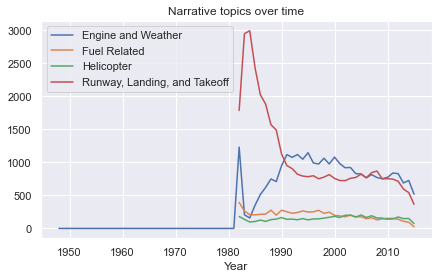

In [39]:
# Changes in the use of words/topics in narrative over time

Merged['c'] = 1
narrative_over_time = pd.pivot_table(Merged, index = ['Year'],
                                     values=['c'],
                                      columns = ['narr_topic_label'],
                                      aggfunc= 'count')
ax = narrative_over_time.plot.line(title='Narrative topics over time', figsize=(7,4))
my_labels = ['Engine and Weather', 'Fuel Related', 'Helicopter', 'Runway, Landing, and Takeoff']
ax.legend(labels = my_labels)

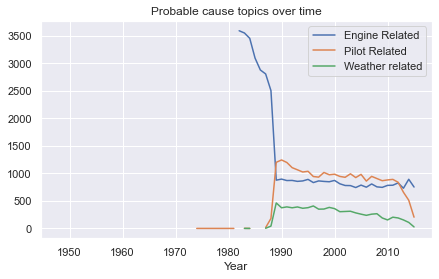

In [40]:
# Changes in probabl cause over time

pc_over_time = pd.pivot_table(Merged, index = ['Year'],
                                     values=['c'],
                                      columns = ['pc_topic_label'],
                                      aggfunc= 'count')
ax = pc_over_time.plot.line(title='Probable cause topics over time', figsize=(7,4))
my_labels = ['Engine Related', 'Pilot Related', 'Weather related']
ax.legend(labels = my_labels)

# Summary of the Aviation Accidents data analysis

The dataset contains a set of variables describing the situational and factual factors associated with each aviation accident predominantly between 1982 and 2015. A separate set of datasets contains the narrative attached to each accident and its probable cause. These were joined to the main dataset.

The exploratory analyses showed several patterns in the accident data. For example, more than 90% of accidents occurred in visual meteorological conditions (VMC), when the visibility condition was adequate. Close to half of accidents occurred during landing and takeoff, whereas about 28% occurred while cruising or maneuvering. In more than 80% of accidents, the aircraft involved had only one engine. 

When looking at the trends of aviation accidents over time, I observed that the number of accidents per year has been decreasing substantially during the examined time period, from more than 3,500 accidents in 1982 to less than 1000 in 2015. It is conceivable that aviation safety has enhanced tremendously over time given improvement in technology, regulations, training, and flying practices. The same downward trend was observed when breaking down accidents that resulted in different types of injuries, including fatal, serious, and minor injuries. Most people involved in these accidents were uninjured, however, when people were injured, they were more likely to be fatally injured. These patterns were presented with several charts. 

Next, I applied topic modeling analyses to the narrative text and probable cause text. Two types of models were applied to the dataset for topic extraction, including the Latent Dirichlet Allocation (LDA) algorithm which calculates the probability of each accident falling under a mixture of distinct categories, and the non-negative matrix factorization (NMF) which calculates the coefficient of each topic in relation to each document. Both require a prespecified number of topic groups to be extracted. The words in the text were first counted and used to create a document term matrix which records the frequencies of each word appearing in each document. I specified to remove any words that showed up in more than 80% (for narrative) or 90% (for probable cause) of documents or showed up only once. After experimenting with different numbers of topic groups, models, and adjusting other parameters, I settled with 5 topic groups for Narratives and Probable Cause, respectively. These groups were further reduced during interpretation into 4 groups for Narratives and 3 groups for Probable Cause. 

For Narratives’ topics, about 48% of accidents involved situations around runway, landing, and takeoff. This aligns with my earlier observation that accidents were most likely to happen during landing and takeoff. About 36% involved engine-related factors and weather conditions. According to the Swiss Cheese Model (Reason et al., 2006), it is common for aviation accidents to involve multiple reasons. About 9% of accidents were fuel-related, and about 7% of accidents likely involved helicopters.

For topics of Probable Cause, about 57% of accidents were related to engine losing power, insufficient fuel, and other failures. About 33% of accidents appeared to be predominantly pilot-related, potentially involving failure to control or maintain the aircraft properly. Finally, about 10% of accidents focused on inadequate flight conditions. 

When looking at topics over time, I observed that runway, landing, and takeoff related narratives have decreased largely over time, whereas engine and weather related narratives have become the most dominant topic after the 1990s. It is possible that accidents during landing and takeoff were much more likely to occur in early years. For probable cause, I saw that prior to late 1980s, engine, fuel, and mechanics related causes were the only focal topic in probable cause. After that, pilot and weather related factors were able to be extracted. This likely has to do with changes in how probable cause was determined or recorded over time. 

Reference
Reason, J., Hollnagel, E., & Paries, J. (2006). Revisiting the Swiss cheese model of accidents. Journal of Clinical Engineering, 27(4), 110-115.